## Lab 2
- Levantar los datos desde el archivo dataset/demanda.csv. Los mismos fueron extraídos de los datos del informe mensual en http://portalweb.cammesa.com/memnet1/Pages/descargas.aspx
- Explorar los datos y visualizar descomposición de datos.
- Modelar con Holt Winters Smoothing con diferentes parámetros.
- Visualizar los resultados y evaluar su poder predictivo, comparando ambos modelos.

In [73]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os
from plotting import fanchart

In [74]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

In [75]:
df = pd.read_csv('./datasets/demanda.csv',
                 dtype={'Año':str,'Trimestre':str},
                 index_col = 'TIPO',
                 parse_dates = True, 
                 dayfirst = True)
df.head()

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
TIPO,,,,
2013-01-01,4538446.146,3319300.732,3276372.467,1.113412e+07
2013-02-01,3961686.119,2820263.212,3052210.676,9.834160e+06
2013-03-01,3612835.111,2861328.931,3281965.266,9.756129e+06
2013-04-01,3239380.702,2826797.310,3241156.151,9.307334e+06
2013-05-01,3919668.996,2948663.278,3364493.120,1.023283e+07


In [76]:
y = df['TOTAL'].copy()
y.index = y.index.to_period(freq='M')
ts = df['TOTAL']

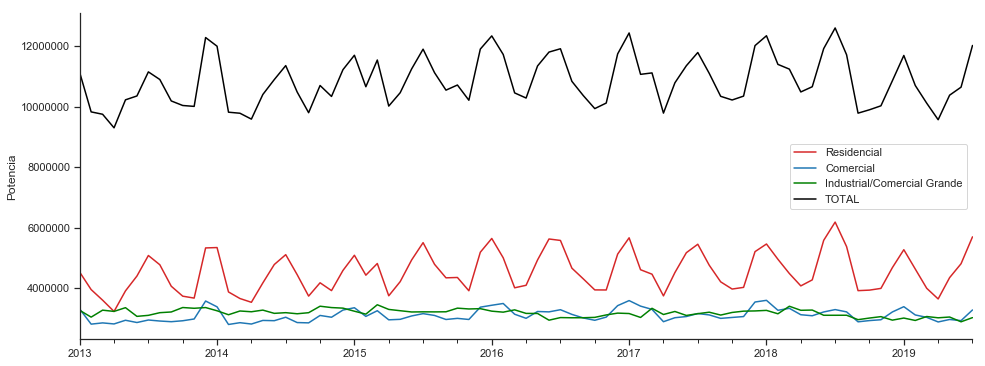

In [77]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.ticklabel_format(style = 'plain')
df['Residencial'].plot(color = red, 
                       label = 'Residencial')
df['Comercial'].plot(color = blue, 
                     label = 'Comercial')
df['Industrial/Comercial Grande'].plot(color = 'green', 
                                       label = 'Industrial/Comercial Grande')
df['TOTAL'].plot(color = 'black', label = 'TOTAL')
ax.set_xlabel('')
ax.set_ylabel('Potencia')
plt.legend(loc = 'best')

sns.despine()
plt.show()

In [78]:
print(ts.describe().round(2))

count          79.00
mean     10853008.74
std        816874.81
min       9307334.16
25%      10223259.40
50%      10706955.32
75%      11476364.98
max      12607552.72
Name: TOTAL, dtype: float64


### Descomposición

In [79]:
decomposition = sm.tsa.x13_arima_analysis(ts.astype(float), x12path = '.')


C:\Users\piaggica\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\statsmodels\tsa\x13.py:187: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in the estimated spectrum of the regARIMA residuals.
  
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


In [80]:
[attr for attr in dir(decomposition) if not attr.startswith('_')]

['irregular', 'observed', 'plot', 'results', 'seasadj', 'stdout', 'trend']

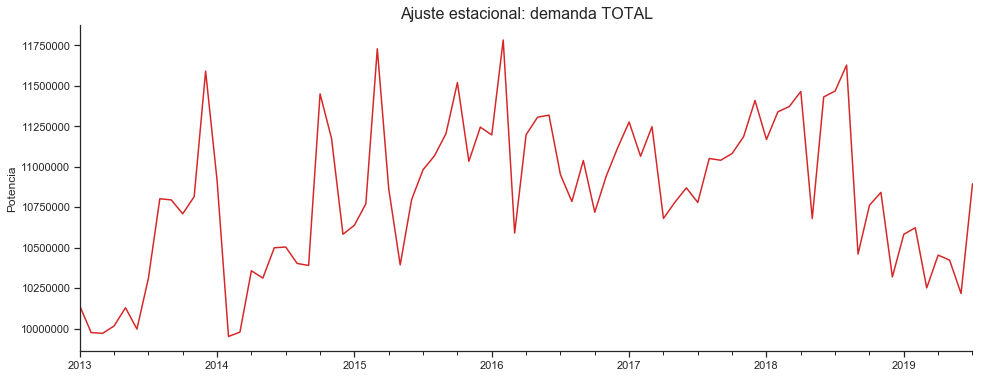

In [81]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.ticklabel_format(style = 'plain')
decomposition.seasadj.plot(color = red)
ax.set_xlabel('')
ax.set_ylabel('Potencia')
ax.set_title('Ajuste estacional: demanda TOTAL', fontsize = 16)
sns.despine()
plt.show()

###### Descomponiendo

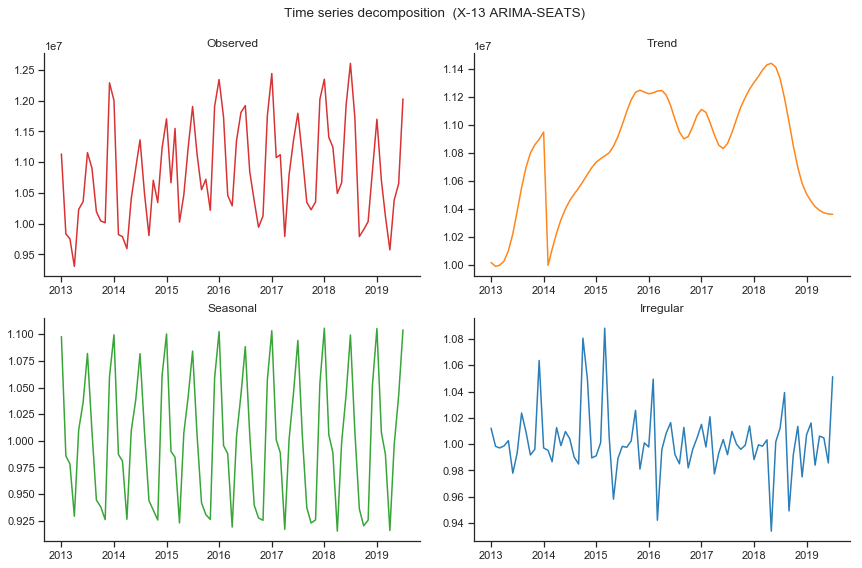

In [82]:
from plotting import plot_components_x13
plot_components_x13(decomposition)
plt.show()

In [83]:
z = decomposition.seasadj.copy()
z.index = ts.index.to_period(freq = 'M')

model_sm = sm.tsa.Holt(z).fit()
smoothed_sm = model_sm.fittedvalues
alpha_sm = model_sm.model.params['smoothing_level']
betha_sm = model_sm.model.params['smoothing_slope']
mse_sm = sm.tools.eval_measures.mse(ts,smoothed_sm)

print(' Smoothing parameter: alpha  {0:.3f}'.format(alpha_sm))
print(' Smoothing parameter: betha  {0:.3f}'.format(betha_sm))
print(' In-sample fit:')
print(' MSE               {0:.3f}'.format(mse_sm))

model_sm.summary()

 Smoothing parameter: alpha  0.384
 Smoothing parameter: betha  0.000
 In-sample fit:
 MSE               608698701812.201


Dep. Variable:,endog,No. Observations:,79
Model:,Holt,SSE,11011658546791.621
Optimized:,True,AIC,2035.182
Trend:,Additive,BIC,2044.659
Seasonal:,None,AICC,2036.348
Seasonal Periods:,None,Date:,"Mon, 14 Oct 2019"
Box-Cox:,False,Time:,12:14:08
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3842037,alpha,True
smoothing_slope,0.000000,beta,True


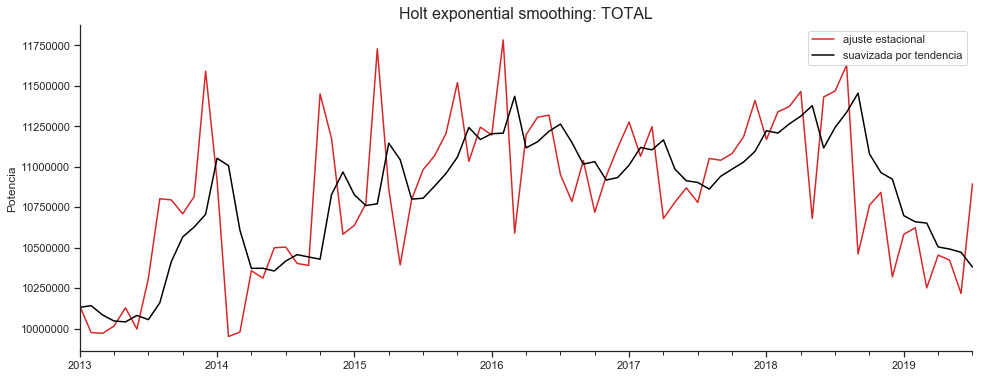

In [84]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.ticklabel_format(style = 'plain')

ax.set_title('Holt exponential smoothing: TOTAL', fontsize = 16)

z.plot(color = '#D62728', label = 'ajuste estacional')
smoothed_sm.plot(color = 'black', label = 'suavizada por tendencia')

plt.legend(loc = 'best')
ax.set_xlabel('')
ax.set_ylabel('Potencia')

sns.despine()
plt.show()

###### Rolling y expanding windows

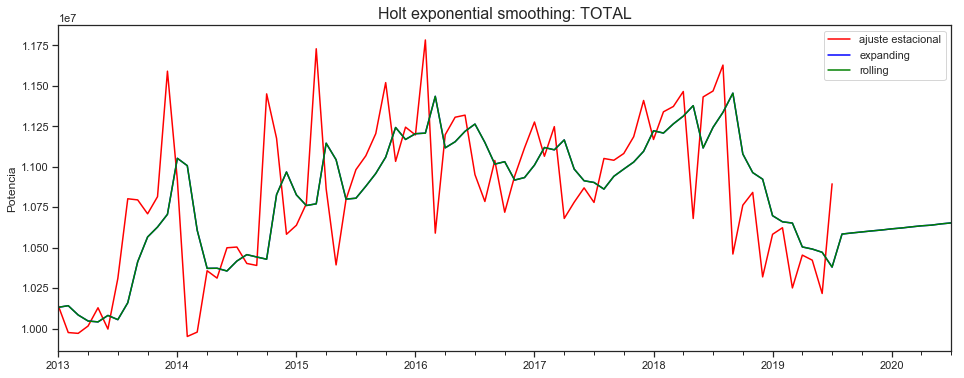

In [85]:
h = 12
w = h * 12
Z = z

model = sm.tsa.Holt
pred_index = Z.index[-1] + np.array(range(1, h + 1))
pred_rolling = pd.Series(0, index = pred_index)
pred_expanding = pd.Series(0, index = pred_index)
orig_fit = None

for i in range(0, h):
    current = pd.concat([Z, pred_expanding.head(i)])
    expanding = model(current).fit()
    if i == 0:
        orig_fit = expanding.fittedvalues
        
    rolling = model(current.tail(w)).fit()
    pred_expanding.update(expanding.forecast(1))
    pred_rolling.update(rolling.forecast(1))
    
ax = Z[-w:].plot(color = 'red', figsize = (16, 6), label = 'ajuste estacional')
ax.set_title('Holt exponential smoothing: TOTAL', fontsize = 16)
ax.set_xlabel('')
ax.set_ylabel('Potencia')

pd.concat([orig_fit[-w:], pred_expanding]).plot(ax = ax, color = 'blue', label = 'expanding')
pd.concat([orig_fit[-w:], pred_rolling]).plot(ax = ax, color = 'green', label = 'rolling')

plt.legend(loc = 'best')
plt.show()

#### Holt Winters Smoothing

In [86]:
def hw_summary(model_sm):
    rmse_sm = sm.tools.eval_measures.rmse(model_sm.data.endog,model_sm.fittedvalues)
    print(' In-sample fit:')
    print(' RMSE               {0:.3f}'.format(rmse_sm))
    return model_sm.summary()

In [87]:
mhw_sm = sm.tsa.ExponentialSmoothing(y,
                                     trend = 'add',
                                     damped = False, 
                                     seasonal = 'mul', 
                                     seasonal_periods = 12).fit()
hw_summary(mhw_sm)

 In-sample fit:
 RMSE               373386.184


Dep. Variable:,endog,No. Observations:,79
Model:,ExponentialSmoothing,SSE,11013962158592.178
Optimized:,True,AIC,2059.198
Trend:,Additive,BIC,2097.109
Seasonal:,Multiplicative,AICC,2070.598
Seasonal Periods:,12,Date:,"Mon, 14 Oct 2019"
Box-Cox:,False,Time:,12:14:10
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3555770,alpha,True
smoothing_slope,5.6174e-14,beta,True


In [88]:
ahw_sm = sm.tsa.ExponentialSmoothing(y, 
                                     trend = 'add',
                                     damped = False, 
                                     seasonal = 'mul', 
                                     seasonal_periods = 12).fit()
hw_summary(ahw_sm)

 In-sample fit:
 RMSE               373386.184


Dep. Variable:,endog,No. Observations:,79
Model:,ExponentialSmoothing,SSE,11013962158592.178
Optimized:,True,AIC,2059.198
Trend:,Additive,BIC,2097.109
Seasonal:,Multiplicative,AICC,2070.598
Seasonal Periods:,12,Date:,"Mon, 14 Oct 2019"
Box-Cox:,False,Time:,12:14:10
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3555770,alpha,True
smoothing_slope,5.6174e-14,beta,True


In [89]:
mhw_damped=sm.tsa.ExponentialSmoothing(y, 
                                       trend='add', 
                                       damped=True, 
                                       seasonal='mul',
                                       seasonal_periods=12).fit()
hw_summary(mhw_damped)

 In-sample fit:
 RMSE               373992.563


Dep. Variable:,endog,No. Observations:,79
Model:,ExponentialSmoothing,SSE,11049764539993.861
Optimized:,True,AIC,2061.455
Trend:,Additive,BIC,2101.735
Seasonal:,Multiplicative,AICC,2074.336
Seasonal Periods:,12,Date:,"Mon, 14 Oct 2019"
Box-Cox:,False,Time:,12:14:14
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3601600,alpha,True
smoothing_slope,0.0526472,beta,True


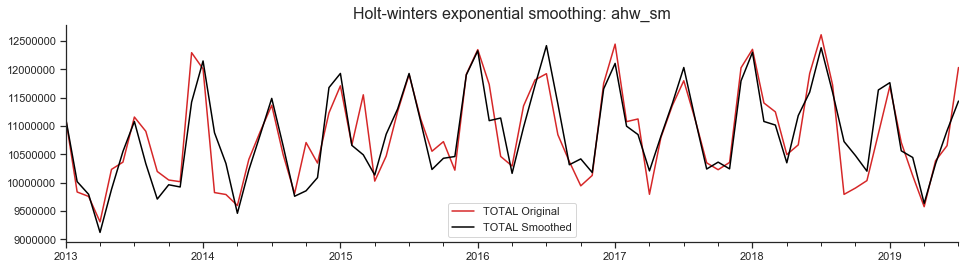

In [90]:
smoothed = pd.Series(ahw_sm.fittedvalues, 
                    index = y.index)

fig, ax = plt.subplots(figsize = (16, 4))
plt.ticklabel_format(style = 'plain')

y.plot(color = '#D62728',
                 label = 'TOTAL Original')
smoothed.plot(color = 'black', 
              label = 'TOTAL Smoothed')

plt.legend(loc = 'best')
ax.set_xlabel('')
ax.set_title('Holt-winters exponential smoothing: ahw_sm', fontsize = 16)
 
sns.despine()
plt.show()

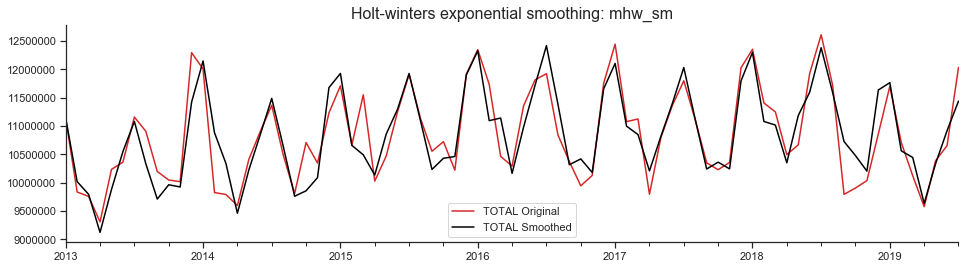

In [91]:
smoothed = pd.Series(mhw_sm.fittedvalues, 
                    index = y.index)

fig, ax = plt.subplots(figsize = (16, 4))
plt.ticklabel_format(style = 'plain')

y.plot(color = '#D62728',
                 label = 'TOTAL Original')
smoothed.plot(color = 'black', 
              label = 'TOTAL Smoothed')

plt.legend(loc = 'best')
ax.set_xlabel('')
ax.set_title('Holt-winters exponential smoothing: mhw_sm', fontsize = 16)
 
sns.despine()
plt.show()

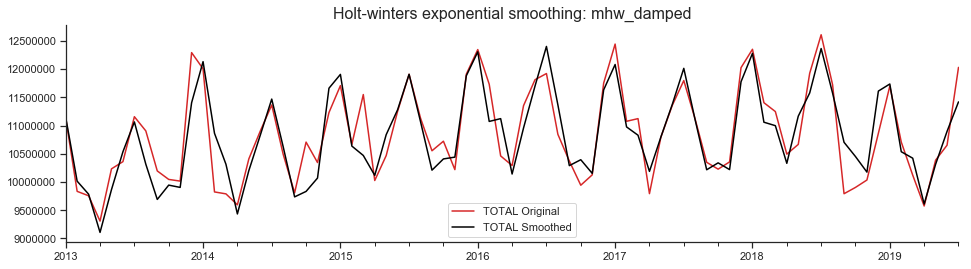

In [92]:
smoothed = pd.Series(mhw_damped.fittedvalues, 
                    index = y.index)

fig, ax = plt.subplots(figsize = (16, 4))
plt.ticklabel_format(style = 'plain')

y.plot(color = '#D62728',
                 label = 'TOTAL Original')
smoothed.plot(color = 'black', 
              label = 'TOTAL Smoothed')

plt.legend(loc = 'best')
ax.set_xlabel('')
ax.set_title('Holt-winters exponential smoothing: mhw_damped', fontsize = 16)
 
sns.despine()
plt.show()

### Diagnóstico del modelo

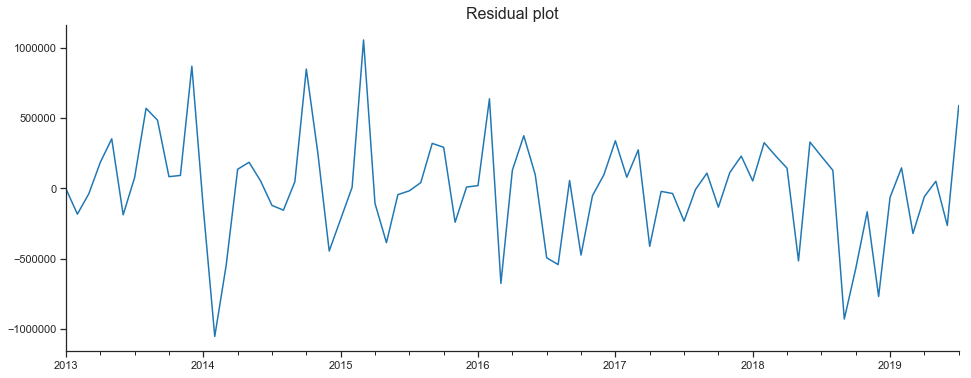

In [93]:
resid = (y - mhw_sm.fittedvalues)

fig, ax = plt.subplots(figsize = (16, 6))
resid.plot(color = blue)
ax.set_xlabel('')
ax.set_title('Residual plot', fontsize = 16)

sns.despine()
plt.show()

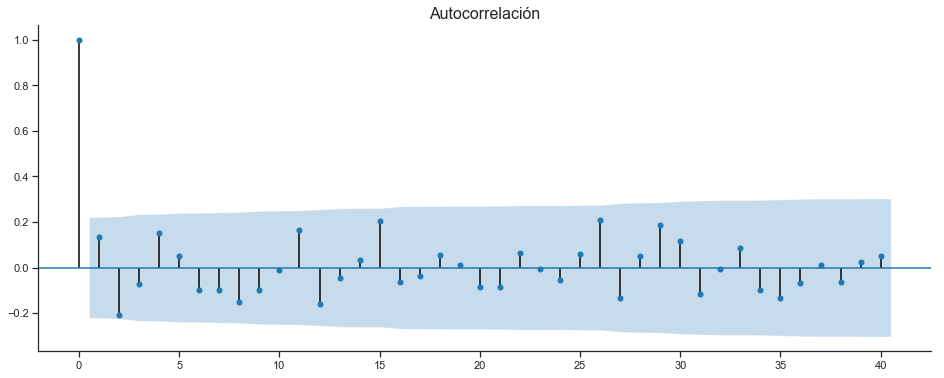

In [94]:
fig, ax = plt.subplots(figsize = (16, 6))

sm.graphics.tsa.plot_acf(resid, lags = 40, ax = ax)
ax.set_title('Autocorrelación', fontsize = 16)

sns.despine()
plt.show()

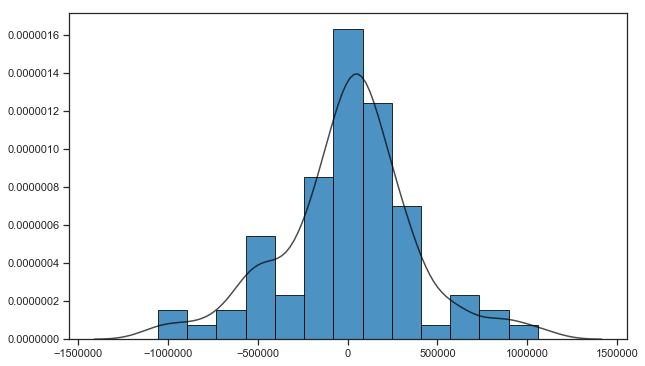

In [95]:
from plotting import histogram

fig, ax = plt.subplots(figsize = (10, 6))
    
sns.distplot(resid, ax = ax, hist_kws = {'alpha': 0.8, 'edgecolor':'black', 'color': blue},  
                 kde_kws = {'color': 'black', 'alpha': 0.7})

plt.show()

### Validación del modelo

In [96]:
start_val = y.index[-round(len(y) / 12 * .2) * 12]
start_val

Period('2018-08', 'M')

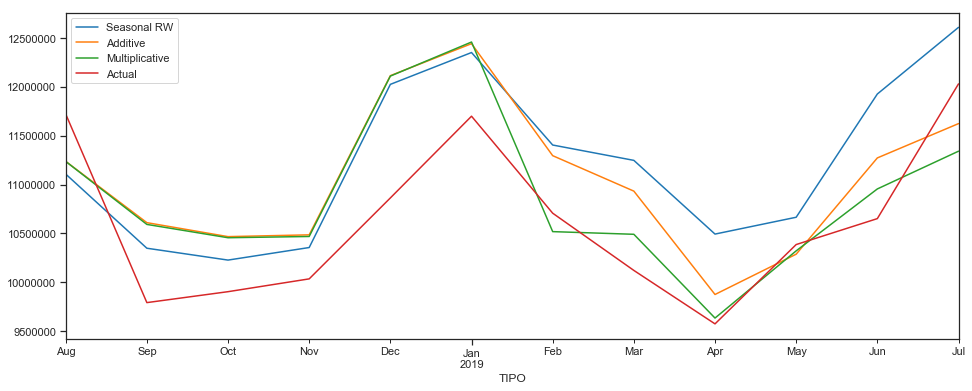

In [97]:
validation = y[start_val:].index
start = y.index.get_loc(start_val) 

pred1 = [] # seasonal random walk
pred2 = [] # additive holt winters
pred3 = [] # multiplicative holt winters
actual= []

for i in range(start, len(y)):
    
    actual.append(y.iloc[i])
    
    pred1.append(y.iloc[i-12])
    
    model = sm.tsa.ExponentialSmoothing(y.iloc[:i], 
                                        trend = 'add', 
                                        damped = False, 
                                        seasonal = 'add', 
                                        seasonal_periods = 12).fit()
    pred2.append(model.forecast(1)[0])
    
    model = sm.tsa.ExponentialSmoothing(y.iloc[:i], 
                                        trend = 'add', 
                                        damped = False, 
                                        seasonal = 'mul',
                                        seasonal_periods = 12).fit()
    pred3.append(model.forecast(1)[0])
    

columns = ['Seasonal RW', 'Additive', 'Multiplicative', 'Actual']
results = np.vstack([pred1, pred2, pred3, actual]).T
results = pd.DataFrame(results, columns = columns, index = validation)

fig, ax = plt.subplots(figsize = (16, 6))
plt.ticklabel_format(style = 'plain')

results.plot(ax = ax)

plt.show()

In [98]:
from scipy import stats

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(len(results.columns)-1):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results.iloc[:,i], results.iloc[:,-1])
    table.iloc[i,1] = (results.iloc[:,i] - results.iloc[:,-1]).sem()
table.round(3)

,RMSE,SE
Seasonal RW,779964.344,148054.667
Additive,657764.443,150172.336
Multiplicative,594545.132,161499.990


#### Forecast

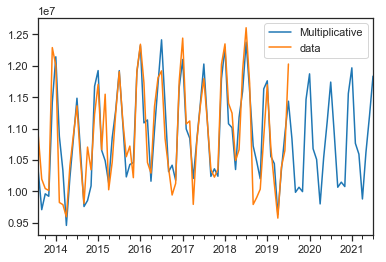

In [99]:
h=2*12 #M
w=h*3

model = sm.tsa.ExponentialSmoothing(y,
                                    trend='add',
                                    damped=False, 
                                    seasonal='mul',
                                    seasonal_periods=12).fit()

plot = pd.DataFrame()
plot['Multiplicative'] = pd.concat([model.fittedvalues, model.forecast(h)])
plot['data'] = y

plot[-(w+h):].plot();#figsize=(9,6))